In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Импорт библиотек

In [1]:
import os      # Библиотека для работы с фаловой системой

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.parallel
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
# import torchvision.datasets as datasets

from tqdm import tqdm

## Загрузка данных

### Гиперпараметры

In [2]:
celeb_img_path = '../input/celeba-dataset/img_align_celeba/' 
device = "cuda" if torch.cuda.is_available() else "cpu"
noise_dim = 100
img_size = 64
epochs = 20
batch_size = 128

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

Загружаем в даталоадер изображения звезд

In [3]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = torchvision.datasets.ImageFolder(root=celeb_img_path, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)

In [4]:
len(dataset)

202599

## Архитектура модели

Реализуем модель из статьи (https://arxiv.org/pdf/1511.06434.pdf). Эта модель будет генерировать лица людей из датасета CelebA

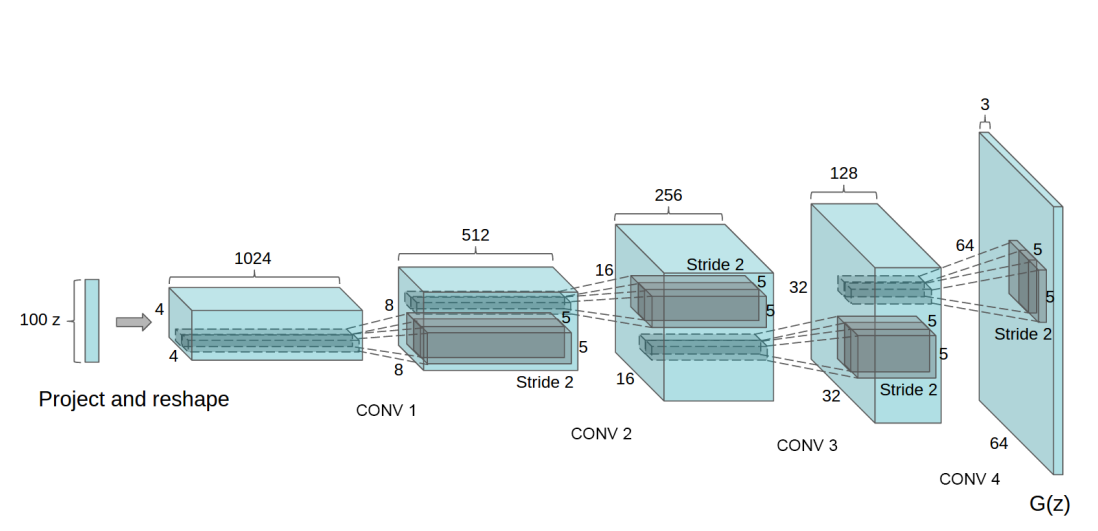

Чуть выше представлена модель генератора. Дискриминатор будет иметь такую же структуру, только зеркально симметрично

### Дискриминатор

In [4]:
def CNA_block_d(in_channels, out_channels, kernel_size, stride, padding):
    x = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True)
    )
    return x

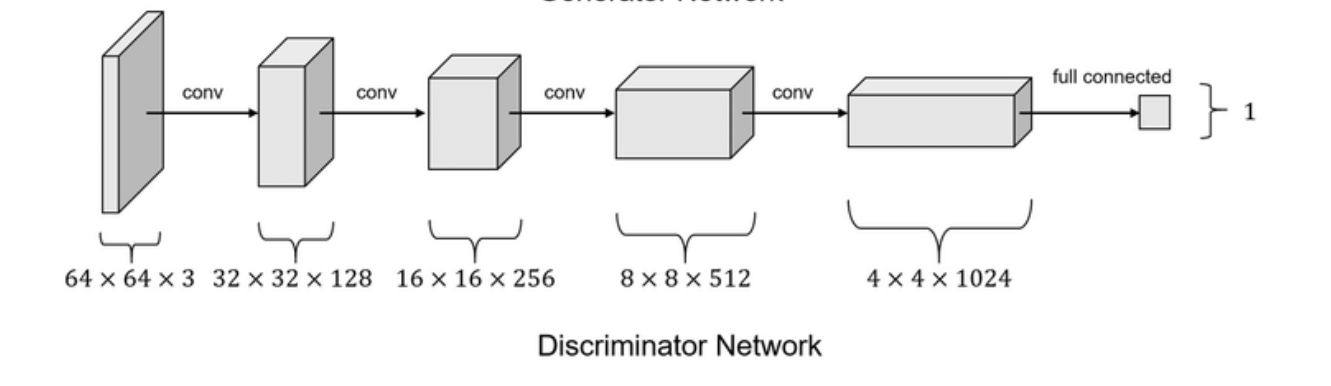

Чуть упростим модель, чтобы быстрее ее обучать

In [5]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super().__init__()
        self.ngpu = ngpu
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            CNA_block_d(64, 128, 4, 2, 1),
            CNA_block_d(128, 256, 4, 2, 1),
            CNA_block_d(256, 512, 4, 2, 1),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.disc(x)

### Генератор

In [6]:
def CNA_block_g(in_channels, out_channels, kernel_size, stride, padding):
    x = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True)
    )
    return x

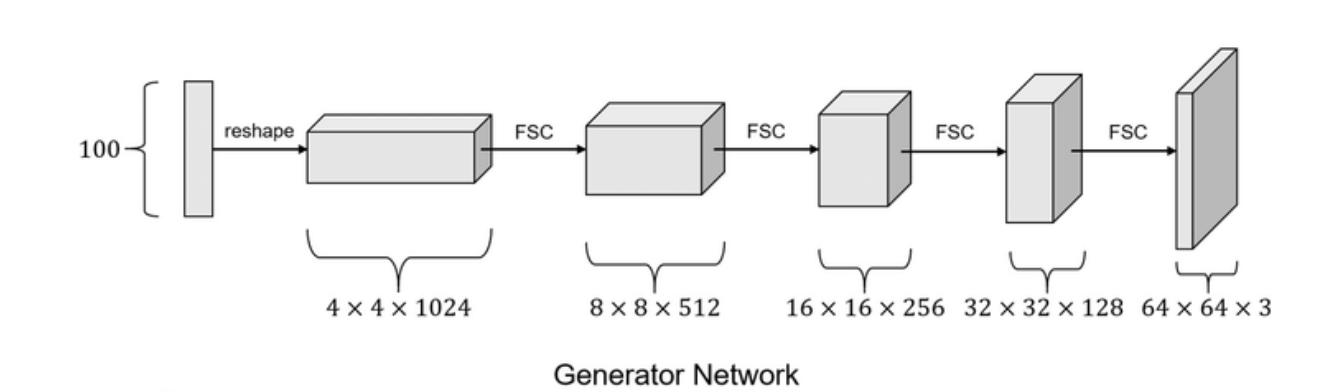

In [7]:
class Generator(nn.Module):
    def __init__(self, noise_channels, img_channels=3):
        super().__init__()
        self.ngpu = ngpu
        self.gen = nn.Sequential(
            CNA_block_g(noise_channels, 512, 4, 1, 0),
            CNA_block_g(512, 256, 4, 2, 1),
            CNA_block_g(256, 128, 4, 2, 1),
            CNA_block_g(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

In [10]:
x = torch.randn(1, 3, 64, 64)
disc = Discriminator()
# disc(x).shape
z = torch.randn(1, 100, 1, 1)
gen = Generator(noise_dim)

if gen(z).shape == x.shape:
    print('Succes!')
    print(f'Output shape:{gen(z).shape}')

Succes!
Output shape:torch.Size([1, 3, 64, 64])


## Инициализация весов

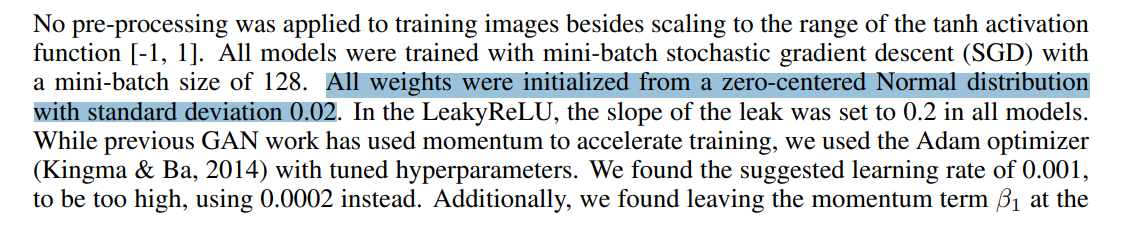

Веса модели задаются из нормального распределения с мат. ожиданием 0 и дисперсией 0.02

In [8]:
def init_weights(m):
    """
    Initialize all weights to mean=0, stdev=0.2
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Обучение

In [9]:
disc = Discriminator().to(device)
gen = Generator(noise_dim).to(device)

if (device == 'cuda') and ngpu > 1:
    disc = nn.DataParallel(disc, device_ids=list(range(ngpu)))
    gen = nn.DataParallel(gen, device_ids=list(range(ngpu)))
    
gen.apply(init_weights)
disc.apply(init_weights)

opt_disc = optim.Adam(disc.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()
torch.cuda.empty_cache()

fixed_noise = torch.randn(64, noise_dim, 1, 1, device=device) # этот шум кидаем в обучаемую модель, чтобы визуализировать обучение модели
fake_imd_list = []

loss_G_list = []
loss_D_list = []

In [12]:
for epoch in tqdm(range(epochs)):
    for batch_idx, (real, label) in enumerate(loader):
        real = real.to(device)

        # Обучение дискриминатора
        disc.zero_grad()
        noise = torch.randn((batch_size, noise_dim, 1, 1)).to(device)
        fake = gen(noise)

        disc_real = disc(real).reshape(-1)
        loss_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake.detach()).reshape(-1)
        loss_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        loss_D = (loss_real + loss_fake)
        loss_D.backward()
        opt_disc.step()
        
        # Обучение генератора
        gen.zero_grad()
        preds = disc(fake).reshape(-1)
        loss_G = criterion(preds, torch.ones_like(preds))
        loss_G.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(f"Epoch:{epoch} **** Loss_D {loss_D:.2f} **** Loss_G {loss_G:.2f}")
            loss_G_list.append(loss_G.cpu().detach().numpy())
            loss_D_list.append(loss_D.cpu().detach().numpy())

            if (epoch + 1) % 2 == 0:
                with torch.no_grad():
                    fake = gen(fixed_noise)

                    fake_img_grid = torchvision.utils.make_grid(fake, normalize=True)
                    fake_imd_list.append(fake_img_grid)




  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:0 **** Loss_D 0.24 **** Loss_G 2.35


  5%|▌         | 1/20 [14:11<4:29:30, 851.08s/it]

Epoch:1 **** Loss_D 0.26 **** Loss_G 2.17


 10%|█         | 2/20 [19:18<2:39:19, 531.06s/it]

Epoch:2 **** Loss_D 0.32 **** Loss_G 2.15


 15%|█▌        | 3/20 [23:58<1:58:05, 416.77s/it]

Epoch:3 **** Loss_D 0.25 **** Loss_G 2.29


 20%|██        | 4/20 [28:42<1:37:08, 364.26s/it]

Epoch:4 **** Loss_D 0.40 **** Loss_G 2.00


 25%|██▌       | 5/20 [33:25<1:23:40, 334.73s/it]

Epoch:5 **** Loss_D 0.35 **** Loss_G 2.14


 30%|███       | 6/20 [38:09<1:14:06, 317.61s/it]

Epoch:6 **** Loss_D 0.25 **** Loss_G 2.39


 35%|███▌      | 7/20 [42:49<1:06:10, 305.45s/it]

Epoch:7 **** Loss_D 0.25 **** Loss_G 2.44


 40%|████      | 8/20 [47:25<59:11, 295.98s/it]  

Epoch:8 **** Loss_D 0.23 **** Loss_G 2.52


 45%|████▌     | 9/20 [52:06<53:24, 291.32s/it]

Epoch:9 **** Loss_D 0.25 **** Loss_G 2.33


 50%|█████     | 10/20 [56:49<48:07, 288.75s/it]

Epoch:10 **** Loss_D 0.23 **** Loss_G 2.51


 55%|█████▌    | 11/20 [1:01:36<43:14, 288.23s/it]

Epoch:11 **** Loss_D 0.26 **** Loss_G 2.47


 60%|██████    | 12/20 [1:06:22<38:20, 287.60s/it]

Epoch:12 **** Loss_D 0.26 **** Loss_G 2.43


 65%|██████▌   | 13/20 [1:11:03<33:18, 285.45s/it]

Epoch:13 **** Loss_D 0.23 **** Loss_G 2.53


 70%|███████   | 14/20 [1:15:43<28:23, 283.92s/it]

Epoch:14 **** Loss_D 0.24 **** Loss_G 2.65


 75%|███████▌  | 15/20 [1:20:31<23:44, 284.96s/it]

Epoch:15 **** Loss_D 0.34 **** Loss_G 2.32


 80%|████████  | 16/20 [1:25:09<18:52, 283.07s/it]

Epoch:16 **** Loss_D 0.32 **** Loss_G 2.21


 85%|████████▌ | 17/20 [1:29:51<14:07, 282.59s/it]

Epoch:17 **** Loss_D 0.26 **** Loss_G 2.44


 90%|█████████ | 18/20 [1:34:31<09:23, 281.75s/it]

Epoch:18 **** Loss_D 0.26 **** Loss_G 2.50


 95%|█████████▌| 19/20 [1:39:14<04:42, 282.42s/it]

Epoch:19 **** Loss_D 0.32 **** Loss_G 2.08


100%|██████████| 20/20 [1:43:55<00:00, 311.76s/it]


In [13]:
# Import pickle Package

import pickle

In [14]:
# Save the Modle to file in the current working directory

Pkl_Filename_g = "Gen.pkl"  
Pkl_Filename_d = "Disc.pkl"  

with open(Pkl_Filename_g, 'wb') as file_g:  
    pickle.dump(gen, file_g)

with open(Pkl_Filename_d, 'wb') as file_d:  
    pickle.dump(disc, file_d)


In [ ]:
# disc_save_name, gen_save_name = 'Disc_1.pkl', 'Gen_1.pkl'

# PATH_disc = f"../input/discrim/{disc_save_name}"
# PATH_gen = f"../input/generator/{gen_save_name}"

# disc.load_state_dict(torch.load(PATH_disc))
# gen.load_state_dict(torch.load(PATH_gen))

In [11]:
disc_save_name, gen_save_name = 'Disc_1.pkl', 'Gen_1.pkl'
PATH_disc = f"../input/discriminator1/{disc_save_name}"
PATH_gen = f"../input/generator1/{gen_save_name}"

with open(PATH_gen, 'rb') as file_g:  
    gen = pickle.load(file_g)

with open(PATH_disc, 'rb') as file_d:  
    disc = pickle.load(file_d)



## Отображение результатов

In [16]:
import matplotlib.pyplot as plt

Посмотрим как обучался генератор на каждой второй эпохе

Здесь показана работа генератора на первых 10 эпохах

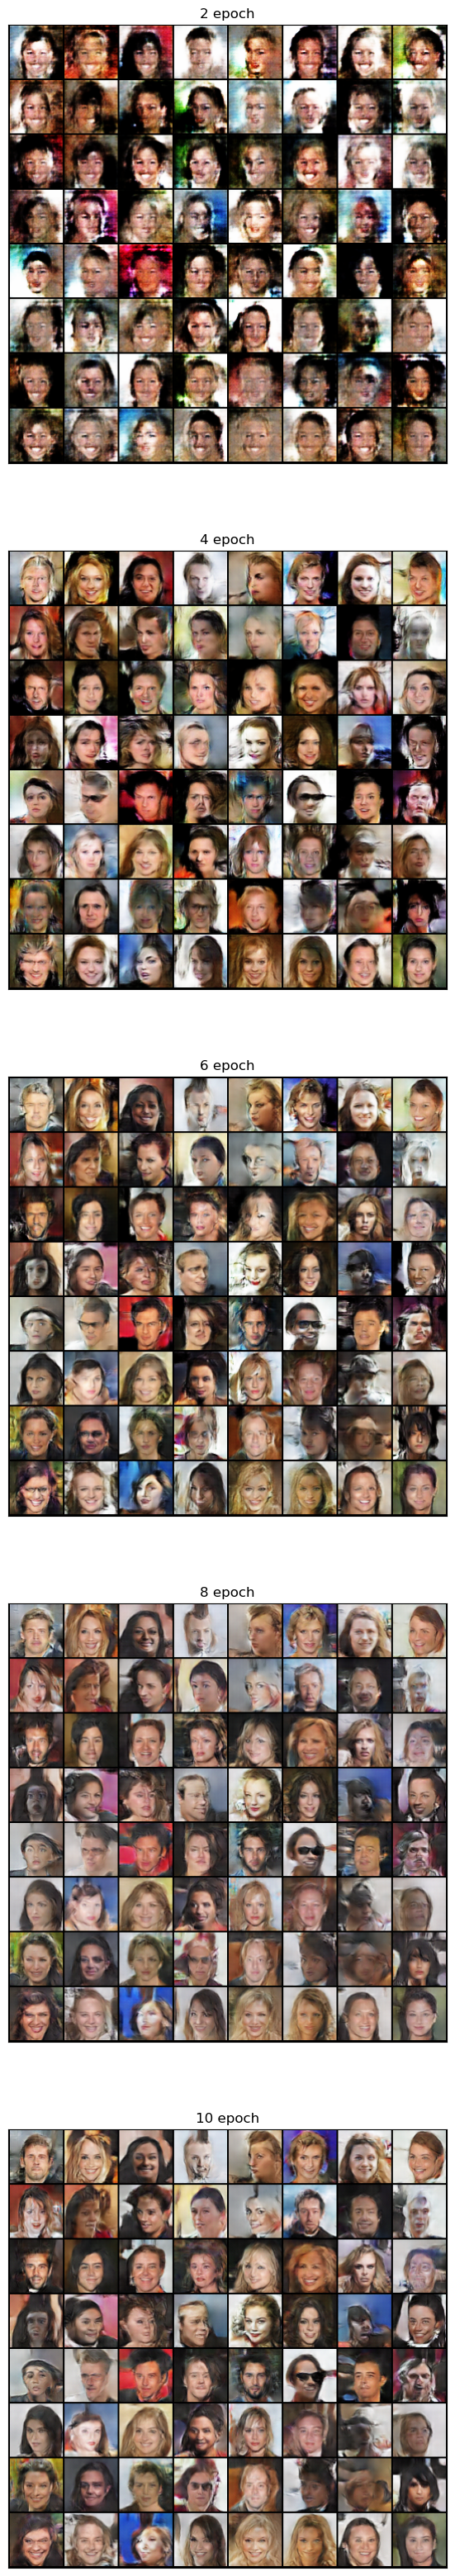

In [20]:
fig, ax = plt.subplots(nrows=len(fake_imd_list), figsize=(40, 40))
ax = ax.flatten()

for i, fake in enumerate(fake_imd_list):
  fake_img = transforms.ToPILImage()(fake)
  ax[i].imshow(fake_img)
  ax[i].set_title(f'{i * 2 + 2} epoch')
  ax[i].get_xaxis().set_visible(False)
  ax[i].get_yaxis().set_visible(False)

Посмотрим на результаты модели на последних 20 эпохах

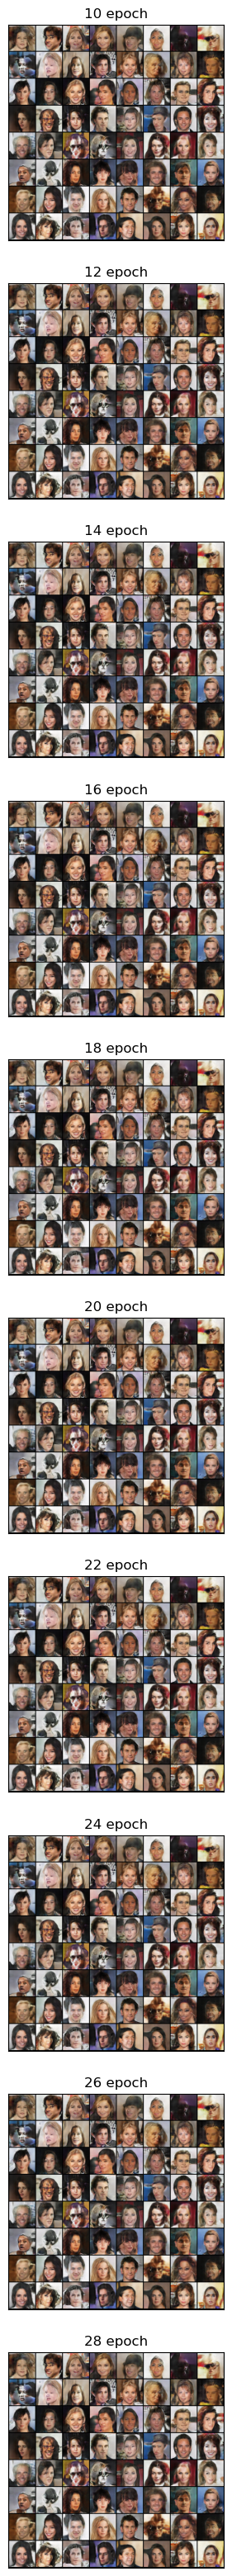

In [26]:
fig, ax = plt.subplots(nrows=len(fake_imd_list), figsize=(80, 40))
ax = ax.flatten()

for i, fake in enumerate(fake_imd_list):
  fake_img = transforms.ToPILImage()(fake)
  ax[i].imshow(fake_img)
  ax[i].set_title(f'{(i + 5) * 2} epoch')
  ax[i].get_xaxis().set_visible(False)
  ax[i].get_yaxis().set_visible(False)

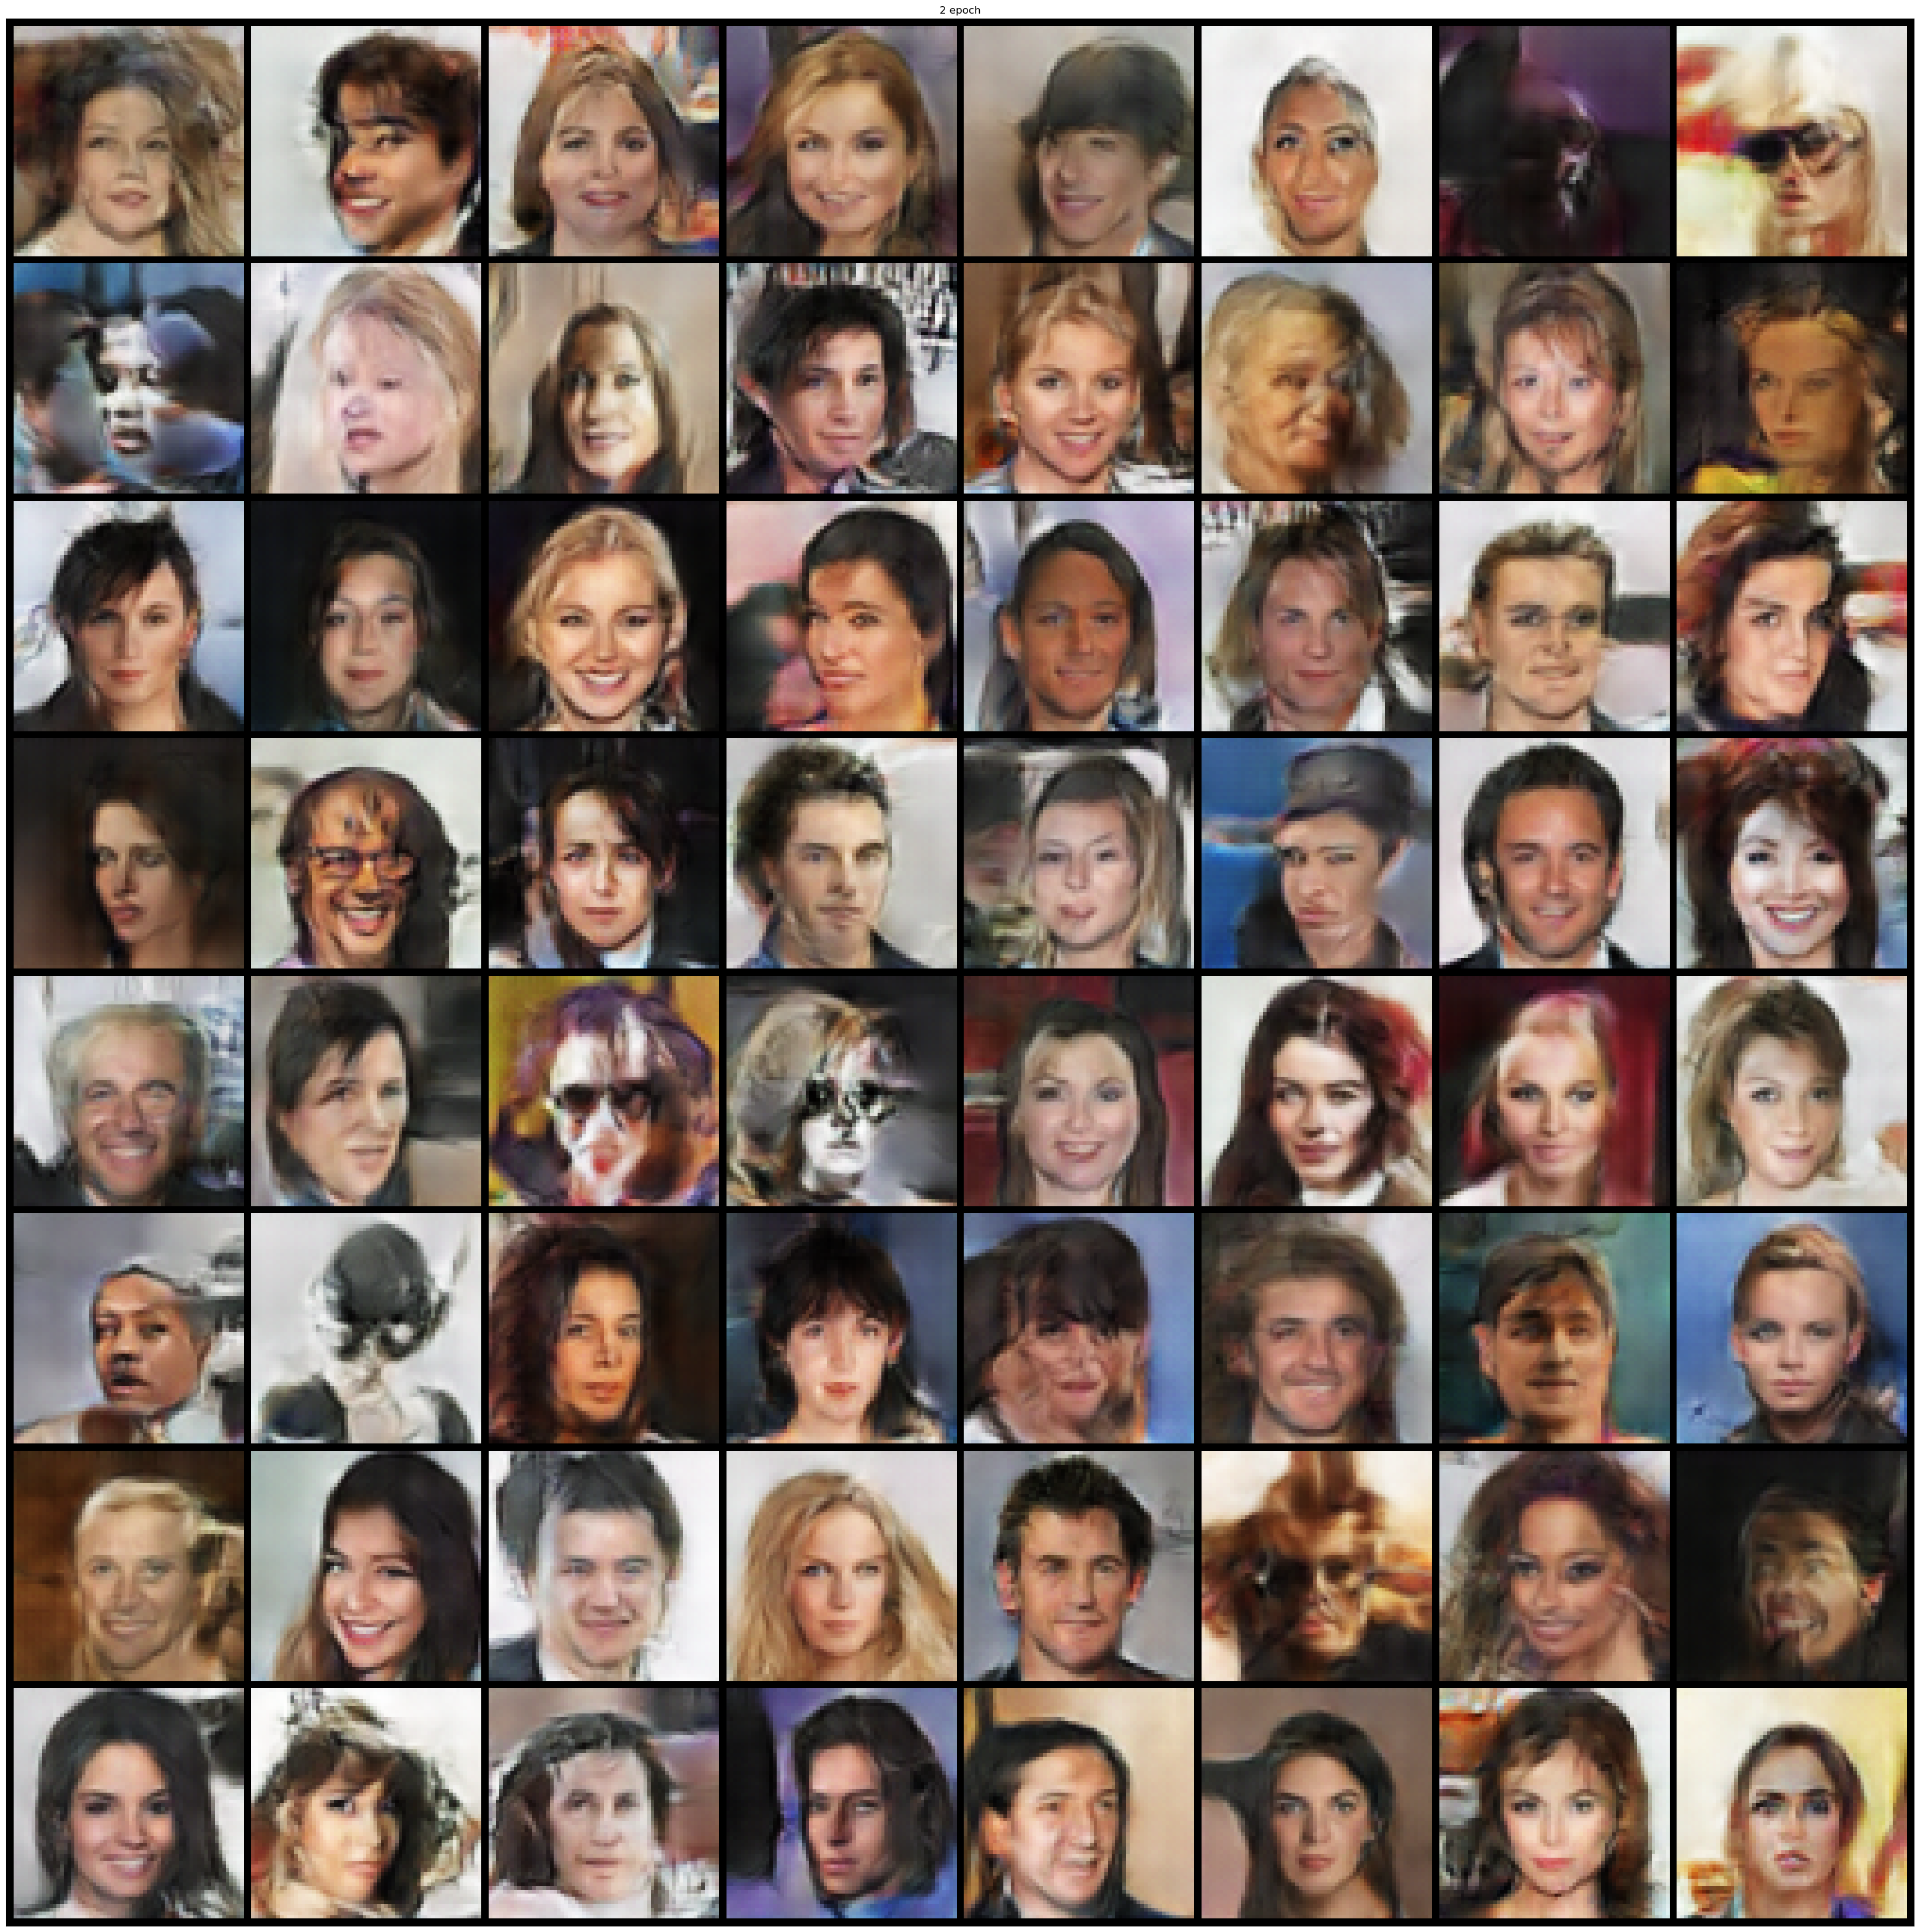

In [25]:
fig, ax = plt.subplots(figsize=(80, 40))
last_epoch_fake = fake_imd_list[-1]
fake_img = transforms.ToPILImage()(last_epoch_fake)
ax.imshow(fake_img)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Выглядит крипово

Выведем также графики функции потерь для генератора и дискриминатора 

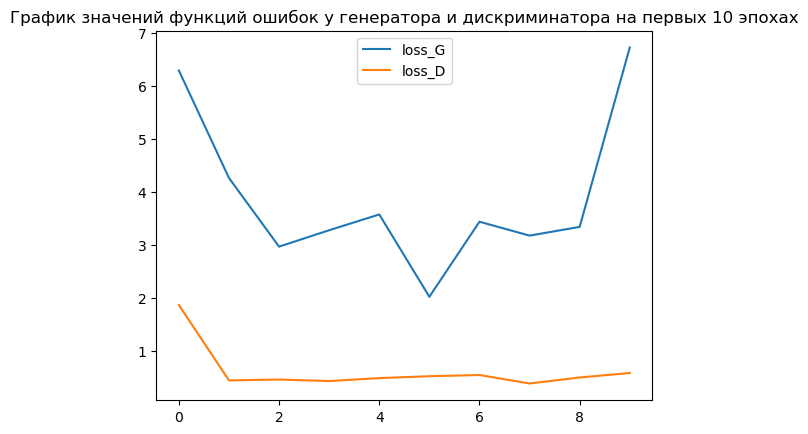

In [22]:
plt.figure()
x = [i for i in range(len(loss_G_list))]

plt.plot(x, loss_G_list, label='loss_G')
plt.plot(x, loss_D_list, label='loss_D')
plt.legend(('loss_G', 'loss_D'))
plt.title('График значений функций ошибок у генератора и дискриминатора на первых 10 эпохах')
plt.show()

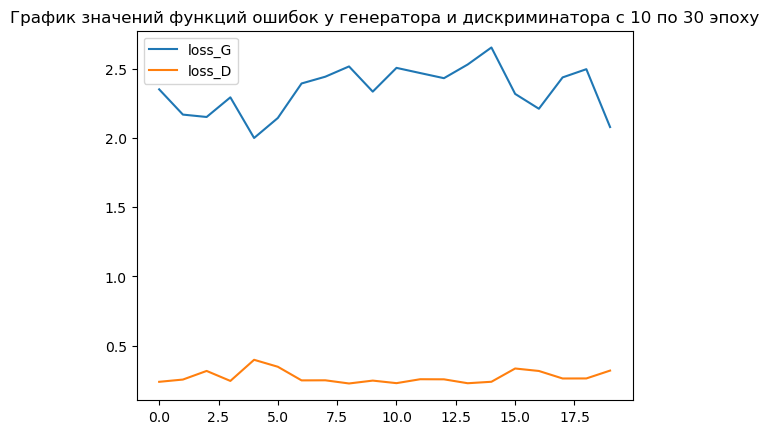

In [19]:
plt.figure()
x = [i for i in range(len(loss_G_list))]

plt.plot(x, loss_G_list, label='loss_G')
plt.plot(x, loss_D_list, label='loss_D')
plt.legend(('loss_G', 'loss_D'))
plt.title('График значений функций ошибок у генератора и дискриминатора c 10 по 30 эпоху')
plt.show()